In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals, unicode_literals

import tensorflow as tf

import numpy as np
import skimage
import cv2
import scipy.io
import pprint
import glob

import PIL as pillow
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import os
import matplotlib


import json

import random
from sklearn.model_selection import train_test_split

import config
from data_util import *
from visualization import *
from metrics import *
from model import *

import open3d
import open3d as o3d

%matplotlib notebook

Using TensorFlow backend.


In [5]:
model_our = load_model(False)
model_our.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.print instead of tf.Print. Note that tf.print returns a no-output operator that directly prints the output. Outside of defuns or eager mode, this operator will not be executed unless it is directly specified in session.run or used as a control dependency for other operators. This is only a concern in graph mode. Below is an example of how to ensure tf.print executes in graph mode:
```python
    sess = tf.Session()
    with sess.as_default():
        tensor = tf.range(10)
        print_op = tf.print(tensor)
        with tf.control_dependencies([print_op]):
          out = tf.add(tensor, tensor)
        sess.run(out)
    ```
Additionally, to use tf.print in python 2.7, users must make sure to import
the following:

  `from __future__ import print_function`

_________________________________________________________________
Layer (type)  

In [27]:
def get_model_2():
    '''
    :return: возвращает арзитектуру сети для Yolo
    '''
    input_image = layers.Input(shape=(IMAGE_H/striding ,IMAGE_W/striding ,IMAGE_D/striding ,1))
    x = layers.Conv3D(filters = 16 ,kernel_size=(5 ,5 ,5) ,strides = (1 ,1 ,1) ,padding = 'same', name = 'conv_0_1') \
        (input_image)
    x = layers.Conv3D(filters = 16 ,kernel_size=(5 ,5 ,5) ,strides = (1 ,1 ,1) ,padding = 'same', name = 'conv_0_2') \
        (x)
    x = layers.BatchNormalization(name='norm_0_1')(x)
    x = layers.advanced_activations.LeakyReLU(alpha=ALPHA)(x)
    x = layers.MaxPool3D(pool_size=(2 ,2 ,1))(x)

    x = layers.Conv3D(filters = 32 ,kernel_size=(5 ,5 ,5) ,strides = (1 ,1 ,1) ,padding = 'same' ,name = 'conv_1_1')(x)
    x = layers.Conv3D(filters = 32 ,kernel_size=(5 ,5 ,5) ,strides = (1 ,1 ,1) ,padding = 'same' ,name = 'conv_1_2')(x)
    x = layers.BatchNormalization(name='norm_1_1')(x)
    x = layers.advanced_activations.LeakyReLU(alpha=ALPHA)(x)
    x = layers.MaxPool3D(pool_size=(4 ,4 ,4))(x)

    x = layers.Conv3D(filters = 32 ,kernel_size=(5 ,5 ,5) ,strides = (1 ,1 ,1) ,padding = 'same', name = 'conv_2_1')(x)
    x = layers.Conv3D(filters = 32 ,kernel_size=(5 ,5 ,5) ,strides = (1 ,1 ,1) ,padding = 'same', name = 'conv_2_2')(x)
    x = layers.BatchNormalization(name='norm_5_1')(x)
    x = layers.advanced_activations.LeakyReLU(alpha=ALPHA)(x)
    x = layers.MaxPool3D(pool_size=(4 ,2 ,2))(x)

    x = layers.Conv3D(filters= 32, kernel_size=(1 ,1 ,1), strides =(1 ,1 ,1), padding = 'same', name= 'pred_yolo')(x)
    x = layers.Conv3D(filters= (4+1+num_classes )*num_boxes, kernel_size=(1 ,1 ,1), strides =(1 ,1 ,1), padding = 'same', name= 'yolo')(x)
    output = layers.Reshape((GRID_H ,GRID_W ,GRID_D ,num_boxes, 4 + 1 + num_classes))(x)
    model = models.Model(input_image, output)
    return model



def load_model_2(load_weights = False):
    model = get_model_2()
    mypotim = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

    model_loss_bend = model_loss()

    model.compile(loss=model_loss_bend, optimizer=mypotim)

    return model

model_our = load_model_2()
model_our.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        (None, 512.0, 128.0, 40.0 0         
_________________________________________________________________
conv_0_1 (Conv3D)            (None, 512.0, 128.0, 40.0 2016      
_________________________________________________________________
conv_0_2 (Conv3D)            (None, 512.0, 128.0, 40.0 32016     
_________________________________________________________________
norm_0_1 (BatchNormalization (None, 512.0, 128.0, 40.0 64        
_________________________________________________________________
leaky_re_lu_36 (LeakyReLU)   (None, 512.0, 128.0, 40.0 0         
_________________________________________________________________
max_pooling3d_34 (MaxPooling (None, 256.0, 64.0, 40.0, 0         
_________________________________________________________________
conv_1_1 (Conv3D)            (None, 256.0, 64.0, 40.0, 64032     
__________

In [6]:
# model_our.load_weights('train_full_train.h5')

In [7]:
# val_loss_arr = np.load('val_loss_progress.npy')
# loss_arr = np.load('loss_progress.npy')


In [26]:
pathname = os.path.abspath('data')
dir_list = os.listdir(pathname)
full_frame_dir = []

for dir_item in dir_list:
    for num in range(40):
        full_frame_dir.append([os.path.join(pathname,dir_item), num])


train_list, test_list = train_test_split(full_frame_dir, train_size = 0.96)


/home/cognitive-comp/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [ ]:
val_loss_arr = []
loss_arr = []

plt.figure()
counter = 0

while True:
    H = model_our.fit_generator(generator_train(full_frame_dir), validation_data= return_val(pathname_val), steps_per_epoch= 60, epochs = 10)
    val_loss_arr.append(H.history['val_loss'])
    loss_arr.append(H.history['loss'])
    
    plt.plot(np.ravel(np.array(val_loss_arr)))
    plt.plot(np.ravel(np.array(loss_arr)))
    plt.show()
    
    if counter%10 == 1:
        metrics_numpy(model_our, directory= directory_val)
    
    counter += 1

Epoch 1/10
60/60 [==============================] - 136s 2s/step - loss: 223108.2120 - val_loss: 13302.8179
Epoch 2/10
60/60 [==============================] - 129s 2s/step - loss: 1337.2852 - val_loss: 2094.4668
Epoch 3/10
60/60 [==============================] - 130s 2s/step - loss: 940.4344 - val_loss: 1213.7119
Epoch 4/10
59/60 [============================>.] - ETA: 2s - loss: 726.5220

In [237]:
model_our.save_weights('classification_12_11_19.h5')

In [96]:
np.save('val_loss_progress.npy', np.ravel(np.array(val_loss_arr)))
np.save('loss_progress.npy', np.ravel(np.array(loss_arr)))
model_our.save('train_full_train.h5')
model_our.save_weights('weights_good_loader.h5')

In [7]:
metrics_numpy(model_our, directory= pathname)

searching in directory/home/cognitive-comp/Рабочий стол/projects/yolo/data
loading /home/cognitive-comp/Рабочий стол/projects/yolo/data/Data_30-May-2018 13-29-23_12.mat
loading /home/cognitive-comp/Рабочий стол/projects/yolo/data/Data_30-May-2018 13-29-23_23.mat
loading /home/cognitive-comp/Рабочий стол/projects/yolo/data/Data_30-May-2018 13-29-23_27.mat
loading /home/cognitive-comp/Рабочий стол/projects/yolo/data/Data_30-May-2018 13-29-23_21.mat
loading /home/cognitive-comp/Рабочий стол/projects/yolo/data/Data_30-May-2018 13-29-23_10.mat
loading /home/cognitive-comp/Рабочий стол/projects/yolo/data/Data_30-May-2018 13-29-23_8.mat
loading /home/cognitive-comp/Рабочий стол/projects/yolo/data/Data_30-May-2018 13-29-23_18.mat
loading /home/cognitive-comp/Рабочий стол/projects/yolo/data/Data_30-May-2018 13-29-23_6.mat
loading /home/cognitive-comp/Рабочий стол/projects/yolo/data/Data_30-May-2018 13-29-23_22.mat
loading /home/cognitive-comp/Рабочий стол/projects/yolo/data/Data_30-May-2018 13-

In [8]:
metrics_numpy_targets(model_our, directory_val)

searching in directory/home/cognitive-comp/Рабочий стол/projects/yolo/val_data
loading /home/cognitive-comp/Рабочий стол/projects/yolo/val_data/Data_30-May-2018 13-29-23_20.mat
avg_iou 0.0002883257003269166
avg_precision 2.1087792698562653e-06
recall50 4.723665564478035e-05
true_counter: 4234


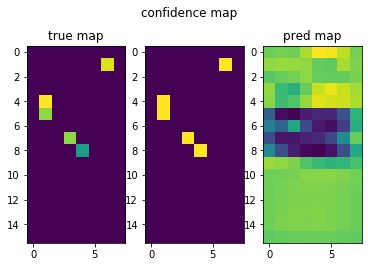

In [11]:
matr = scipy.io.loadmat(os.path.join(pathname, os.listdir(pathname)[1]))
# matr = scipy.io.loadmat(os.path.join(directory_val, os.listdir(directory_val)[0]))
frame,targets, y_true = process_matfile(matr, 10)

y_pred = model_our.predict(frame)

show_comparison_object_level(y_true, y_pred)

In [12]:
boxes = decode_netout(y_pred)
print(len(boxes), boxes)

295 [[18.739177703857422, 55.26749277114868, 33.38019847869873, 96.11053168773651, 0.6063383, 0], [17.565311431884766, 55.98100709915161, 177.64375776052475, 76.74311459064484, 0.6679982, 0], [19.571001052856445, 54.72348880767822, 30.464038252830505, 72.29543030261993, 0.68216556, 0], [16.929365158081055, 55.77603054046631, 194.6946945786476, 83.01320433616638, 0.69065, 0], [19.649551391601562, 54.45592260360718, 32.442706823349, 72.27164804935455, 0.71337366, 0], [16.825706481933594, 71.93792819976807, 154.2848601937294, 62.062857151031494, 0.65285224, 0], [20.16238784790039, 70.25863265991211, 22.955243289470673, 61.9393989443779, 0.6960271, 0], [18.14733123779297, 71.6982569694519, 189.48943316936493, 61.35960578918457, 0.7955996, 0], [23.928150177001953, 68.93598890304565, 21.30596786737442, 29.429136961698532, 0.82815325, 0], [16.927640914916992, 71.32905387878418, 207.54989981651306, 76.40032052993774, 0.8297608, 0], [24.598581314086914, 68.47749376296997, 22.82302975654602, 29.

KeyError: 0

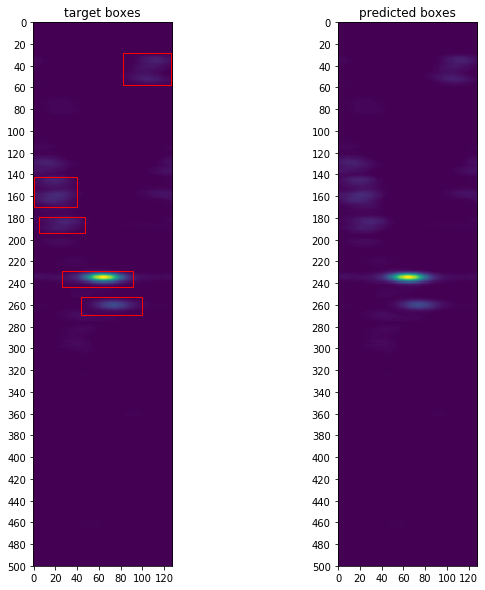

In [13]:
visualise_bird_view(frame,np.expand_dims(targets,0), boxes)

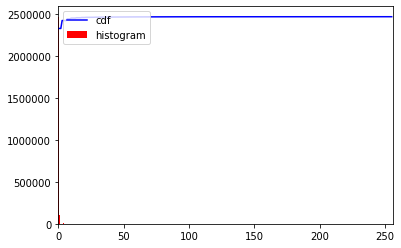

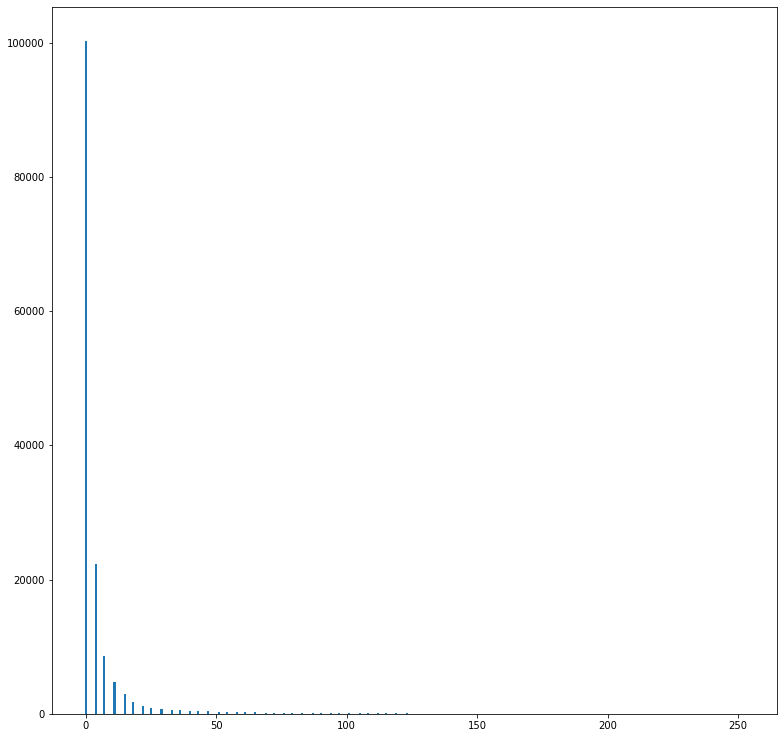

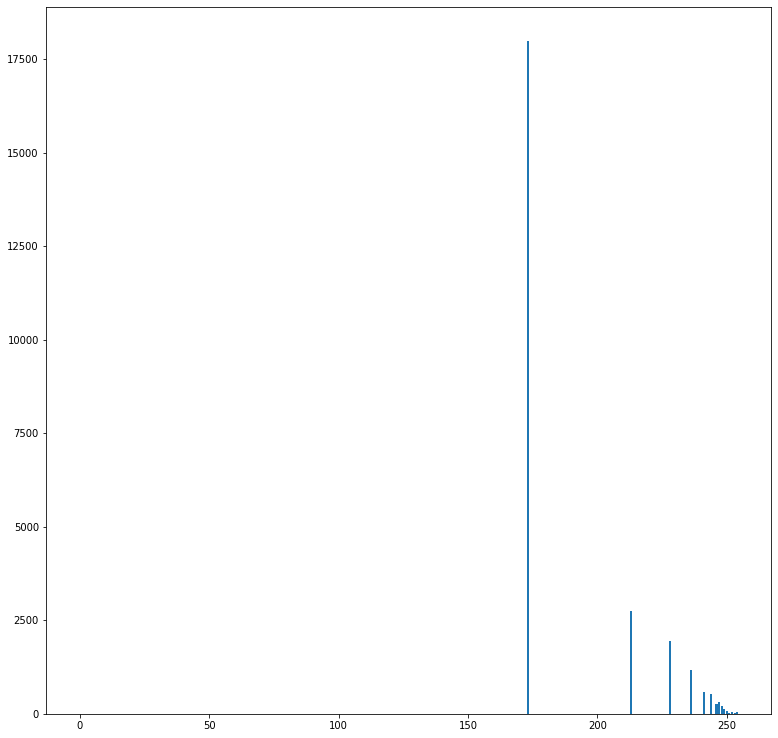

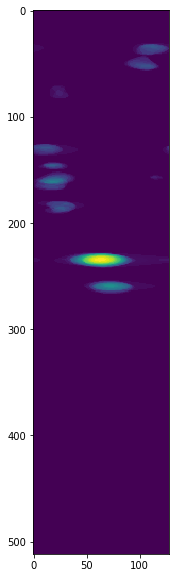

In [14]:
histogram_array = np.histogram(frame[0,...,0],bins = 256)
cdf = histogram_array[0].cumsum()
cdf_normalized = cdf*histogram_array[0].max()/cdf.max()


# print(histogram_array)

plt.plot(cdf_normalized, color = 'b')
plt.hist(frame.flatten(),256, color = 'r')
plt.xlim([0,256])
plt.legend(('cdf','histogram'), loc = 'upper left')
plt.show()

cdf_m = np.ma.masked_equal(cdf,0)
cdf_m = (cdf_m - cdf_m.min())*255/(cdf_m.max()-cdf_m.min())
cdf = np.ma.filled(cdf_m,0).astype('uint8')

frame_equalised = cdf[frame[0,...,0]]

plt.figure(figsize = (13,13))
plt.bar(range(len(histogram_array[0][3:])),histogram_array[0][3:])
plt.show()


histogram_array_equalised = np.histogram(frame_equalised,bins = 256)
plt.figure(figsize = (13,13))
plt.bar(range(len(histogram_array_equalised[0][1:])), histogram_array_equalised[0][1:])
plt.show()

plt.figure(figsize = (10,10))
plt.imshow(np.sum(frame_equalised,2))
plt.show()

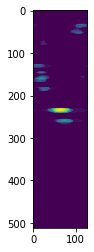

In [46]:
from skimage import data
from skimage import filters

val = filters.threshold_otsu(frame_equalised)
mask = frame_equalised > val

plt.imshow(np.sum(mask,2))

from skimage import measure
all_labels = measure.label(mask)


from skimage.morphology import watershed
from skimage.feature import peak_local_max
import skimage


from scipy import ndimage
distance = ndimage.distance_transform_edt(frame_equalised)
local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((3, 3,3)), labels=frame_equalised)
markers = skimage.morphology.label(local_maxi)
labels_ws = watershed(-distance, markers, mask=frame_equalised)


In [51]:
from ipywidgets import interact

# mask = mask.astype(np.int8)


def f(x):
    plt.figure(figsize = (15,15))
    if x in list(range(all_labels.shape[-1])):
        plt.imshow(all_labels[...,x])
    return x


interact(f,x = (0, all_labels.shape[-1]-1))

interactive(children=(IntSlider(value=19, description='x', max=39), Output()), _dom_classes=('widget-interact'…

<function __main__.f(x)>

In [72]:
def f(x):
    if x in list(range(labels_ws.shape[-1])):
        plt.imshow(labels_ws[...,x])
    return x

plt.figure(figsize = (9,9))
interact(f,x = (0, labels_ws.shape[-1]-1))

<Figure size 648x648 with 0 Axes>

interactive(children=(IntSlider(value=19, description='x', max=39), Output()), _dom_classes=('widget-interact'…

<function __main__.f(x)>

In [53]:
import scipy.ndimage
targets_generated = scipy.ndimage.find_objects(all_labels)

In [70]:
def filtering_boxes(bounds):
    min_size = 600
    
    dim_size = [item_dim[1] - item_dim[0] for item_dim in bounds]
    
    box_prod = np.prod(dim_size)
    
    print(dim_size)
    print(box_prod)
    print(box_prod < min_size)
    if box_prod > min_size:
        return bounds
    else:
        return 0

In [74]:
targets_matric = np.zeros((len(targets_generated), 2*N_DIM))

count = 0
bounding_boxes = []
for ind in range(len(targets_generated)):
    item = targets_generated[ind]
    bounds = [(item[j].start,item[j].stop) for j in range(len(item))]
    bounds_processed = filtering_boxes(bounds)
    if bounds_processed == 0:
        continue
    count += 1
#     print(bounds)
    bbox = []
    for dim in range(len(bounds)):
        start = bounds[dim][0]
        end = bounds[dim][1]
        center = (end + start)/2
        width = (end - start)
        bbox.append([center,width])
#     print(bbox[0][0], bbox[1][0], bbox[2][0],bbox[0][1], bbox[1][1], bbox[2][1])
    bounding_boxes.append([bbox[0][0], bbox[1][0], bbox[2][0],bbox[0][1], bbox[1][1], bbox[2][1]])
    
print(count)

# np.array(bounding_boxes)

[12, 34, 10]
4080
False
[(31, 43), (94, 128), (30, 40)]
37.0 111.0 35.0 12 34 10
[8, 10, 1]
80
True
[14, 33, 9]
4158
False
[(43, 57), (86, 119), (22, 31)]
50.0 102.5 26.5 14 33 9
[12, 18, 3]
648
False
[(71, 83), (16, 34), (37, 40)]
77.0 25.0 38.5 12 18 3
[11, 42, 9]
4158
False
[(126, 137), (0, 42), (28, 37)]
131.5 21.0 32.5 11 42 9
[8, 6, 7]
336
True
[7, 24, 8]
1344
False
[(143, 150), (9, 33), (19, 27)]
146.5 21.0 23.0 7 24 8
[5, 25, 3]
375
True
[13, 37, 8]
3848
False
[(152, 165), (3, 40), (24, 32)]
158.5 21.5 28.0 13 37 8
[5, 12, 3]
180
True
[14, 33, 9]
4158
False
[(156, 170), (0, 33), (12, 21)]
163.0 16.5 16.5 14 33 9
[2, 8, 1]
16
True
[10, 43, 8]
3440
False
[(180, 190), (5, 48), (28, 36)]
185.0 26.5 32.0 10 43 8
[1, 5, 1]
5
True
[8, 25, 5]
1000
False
[(184, 192), (11, 36), (11, 16)]
188.0 23.5 13.5 8 25 5
[15, 108, 27]
43740
False
[(228, 243), (20, 128), (13, 40)]
235.5 74.0 26.5 15 108 27
[4, 7, 1]
28
True
[1, 4, 1]
4
True
[2, 9, 1]
18
True
[13, 67, 15]
13065
False
[(254, 267), (48

[37.0, 111.0, 35.0, 12, 34, 10]
[50.0, 102.5, 26.5, 14, 33, 9]
[77.0, 25.0, 38.5, 12, 18, 3]
[131.5, 21.0, 32.5, 11, 42, 9]
[146.5, 21.0, 23.0, 7, 24, 8]
[158.5, 21.5, 28.0, 13, 37, 8]
[163.0, 16.5, 16.5, 14, 33, 9]
[185.0, 26.5, 32.0, 10, 43, 8]
[188.0, 23.5, 13.5, 8, 25, 5]
[235.5, 74.0, 26.5, 15, 108, 27]
[260.5, 81.5, 32.5, 13, 67, 15]


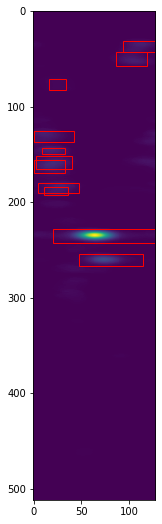

In [76]:
im = np.sum(frame,axis = (0,3,4))

fig,ax = plt.subplots(1, figsize = (9,9))

# Display the image
ax.imshow(im)



for box in bounding_boxes:
    x = box[1]
    y = box[0]
    w = box[4]
    h = box[3]
    print(box)
    x_t = x-w/2
    x_b = x+w/2 
    y_t = y-h/2
    y_b = y+h/2
    rect = patches.Rectangle((x_t,y_t),w,h,linewidth=1,edgecolor='r',facecolor='none')
    ax.add_patch(rect)

plt.show()